### Problem Statement 

Our team aims to build a classifier model to predict presence of West Nile Virus in Chicago supporting the Chicago Department of Public Health in its efforts to prevent West Nile Virus, enabling the Chicago Department of Public Health to redirect its resources to the appropriate infected areas and lower the number of human infections.


While the AUC-ROC score will be important for the team while submitting through Kaggle, one of the main priorities of this project was to also focus on the false negatives. False negatives happens when the model gives a wrong prediction of the not having the west nile virus when in actual fact, the west nile virus is present. It will be vital to minimize the cases with false negatives as the resources will not be directed to those in need if the model is not predicting it correctly. As such, we will also have to prioritise the recall - how accurate the model is in identifying west nile virus.

As such, we will be evaluating our models by optimising these two areas:

ROC-AUC score
Recall score

- 1.0 Baseline model
- 2.0 Logistic Regression (baseline model)
- 3.0 RidgeClassifier with oversampling (SMOTE)
- 4.0 Coefficients from RidgeClassifier
- 5.0 Deep Learning using TensorFlow
- 6.0 Pipeline and Gridsearch Execution
- 7.0 Summary

In [ ]:
#!pip install imblearn
#!pip install xgboost 
#!pip install lightgbm

In [ ]:
#import packages
import timeit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score,plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
    
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

from tensorflow.keras.optimizers import Adam, SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [ ]:
#load the data that has been preprocessed

df_train = pd.read_csv("/datasets/data/train_modelready.csv")
df_predict = pd.read_csv("/datasets/data/test_modelready.csv")


In [ ]:
#check the shape
print("Train :", df_train.shape, " Predict :", df_predict.shape)

Train : (8610, 364)  Predict : (116293, 364)


In [ ]:
#validate there is no null
df_train.isnull().sum().sum()

0

## 1.0 Baseline model

In [ ]:
df_train['WnvPresent'].value_counts(normalize=True)

0.0    0.946922
1.0    0.053078
Name: WnvPresent, dtype: float64

***Our negative class is (WNV is not present) is 95%, we have imbalance dataset***

In [ ]:
#Define X, and Y
X=df_train.drop(columns=['WnvPresent'])
y=df_train['WnvPresent']

In [ ]:
#Train, Test, Split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, shuffle=True, random_state=42)
print("Train split :", X_train.shape, y_train.shape)
print("Test split :", X_test.shape, y_test.shape)

Train split : (6457, 363) (6457,)
Test split : (2153, 363) (2153,)


In [ ]:
#let's scale our X 

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

### 2.0 Logistic Regression (baseline model)

In [ ]:
lr = LogisticRegression(random_state = 42,max_iter=10000)
lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [ ]:
#predict test dataset
y_preds = lr.predict(X_test_scaled)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


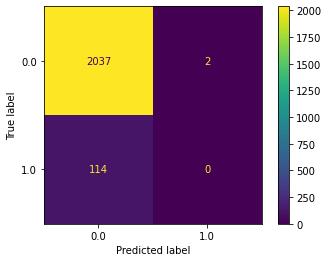

In [ ]:
#confusion matrix 
plot_confusion_matrix(lr, X_test_scaled, y_test)

In [ ]:
#confusion matrix details
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print(tn, fp, fn, tp )

2037 2 114 0


In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      2039
         1.0       0.00      0.00      0.00       114

    accuracy                           0.95      2153
   macro avg       0.47      0.50      0.49      2153
weighted avg       0.90      0.95      0.92      2153



In [ ]:
print('Train Score: ', lr.score(X_train_scaled, y_train), 'Test Score: ', lr.score(X_test_scaled, y_test))
print('ROC_AUC Score: ', roc_auc_score(y_test, y_preds.ravel()))

Train Score:  0.9468793557379588 Test Score:  0.9461216906641895
ROC_AUC Score:  0.49950956351152526


The logistic regression model will act as our baseline model of which which any results that falls below baseline model results will be rejected.We will be optimising for ROC-AUC and recall for this project and our baseline ROC-AUC score is 51.89% ROC-AUC.

If you look at the confusion matrix, the model was only able to accurately predict only 5 positive case. This is because we have imbalance dataset. Hence we will be using SMOTE for future models.

### 3.0  Oversampling using SMOTE ( Synthetic Minority Oversampling Technique)
To addressed imbalanced dataset we will use SMOTE, and build a RidgeClassifier model

In [ ]:
print('Positive Class before SMOTE', sum(y_train)/len(y_train) * 100, ' %')

Positive Class before SMOTE 5.3120644262041194  %


In [ ]:
#oversampling

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)

print(X_smote.shape, y_smote.shape)
print('Positive Class with SMOTE', sum(y_smote)/len(y_smote) * 100, ' %')


(12228, 363) (12228,)
Positive Class with SMOTE 50.0  %


In [ ]:
#use RidgeClassifier to take advnatage of regularization

ridge = RidgeClassifier(random_state = 42)
ridge.fit(X_smote, y_smote)

RidgeClassifier(random_state=42)

In [ ]:
#predict test dataset
y_preds = ridge.predict(X_test_scaled)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


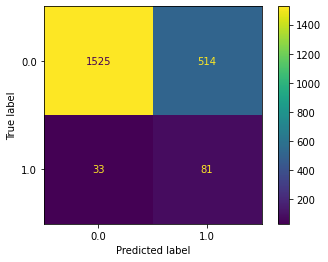

In [ ]:
#confusion matrix
plot_confusion_matrix(ridge, X_test_scaled, y_test);

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print(tn, fp, fn, tp )

1525 514 33 81


In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.98      0.75      0.85      2039
         1.0       0.14      0.71      0.23       114

    accuracy                           0.75      2153
   macro avg       0.56      0.73      0.54      2153
weighted avg       0.93      0.75      0.82      2153



In [ ]:
print('Train Score: ', ridge.score(X_train_scaled, y_train), 'Test Score: ', ridge.score(X_test_scaled, y_test))
print('ROC_AUC Score: ', roc_auc_score(y_test, y_preds.ravel()))

Train Score:  0.7627381136750813 Test Score:  0.7459359033906178
ROC_AUC Score:  0.729220980356728


***This is much better version where we use SMOTE and Ridge for regularizing our features***
- Baseline model, ROC is 50%
- Ridge w SMOTE, ROC is 73%

## 4.0 Coefficients (RidgeClassifier model)

In [ ]:
# calculating coefficients
coeff = pd.DataFrame(X_train.columns)
coeff['Coefficient Estimate'] = pd.Series(ridge.coef_.tolist()[0])

In [ ]:
coeff.rename(columns={0:"Feature"}, inplace=True)
coeff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363 entries, 0 to 362
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Feature               363 non-null    object 
 1   Coefficient Estimate  363 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [ ]:
#we will use this for sorting
coeff['abs_val'] = abs(coeff['Coefficient Estimate'])

#top 50 features
coeff_50 = coeff.sort_values(by='abs_val',ascending=False)[:50]


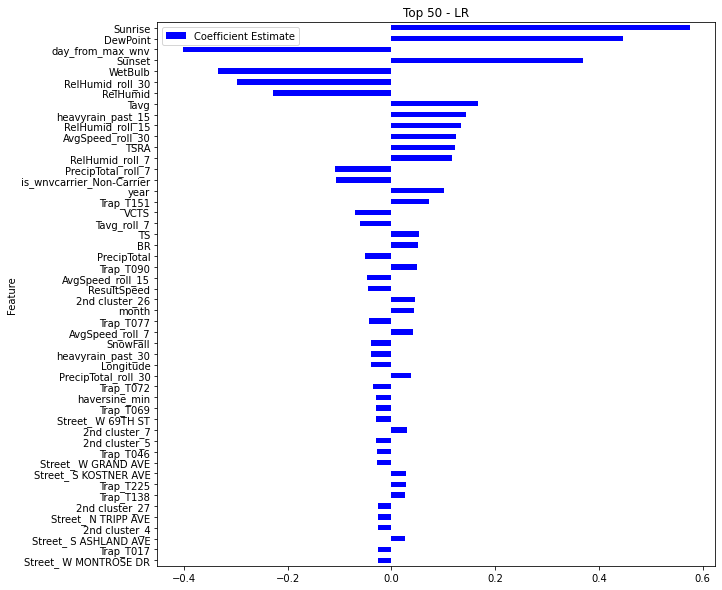

In [ ]:
#our top 50 coefficient using RidgeClassifier
coeff_50.sort_values(by='abs_val').plot(y='Coefficient Estimate',x='Feature',kind='barh', figsize=(10,10), color='b', 
                                  title='Top 50 - LR');

Most of the featured engineer appeared in the top coefficient even though they did not have a high correlation with WnvPresent in the previous notebook.

### 5.0 Deep Learning using TensorFlow - Keras

In this section, we will explore deep learning and how the model weigh up with the simple models we built prior. We will use tensorflow with regularization, dropout and early stop.

In [ ]:
#Define X, and Y
X=df_train.drop(columns=['WnvPresent'])
y=df_train['WnvPresent']

#Train, Test, Split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, shuffle=True)

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)


In [ ]:
from tensorflow.keras.regularizers import l2

model = Sequential()
n_input = X_smote.shape[1]
model.add(Dense(300, # How many nodes/neurons do you want in your first layer.
                input_shape=(n_input,),
                activation='relu',
               kernel_regularizer=l2(0.01)))  #we proved that having regularizer improves our model
model.add(Dense(100, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Compile
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Model Fit
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=30, 
                           mode='auto')

history = model.fit(
    X_smote,
    y_smote,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=512,
    callbacks=[early_stop] # Add your callbacks here!
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               109200    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 80)                8080      
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_3 (Dense)             (None, 50)                4050      
                                                                 
 dense_4 (Dense)             (None, 20)                1020      
                                                                 
 dense_5 (Dense)             (None, 1)                 2

In [ ]:

history.history['accuracy'][-1], history.history['val_accuracy'][-1]

(0.9671246409416199, 0.8871342539787292)

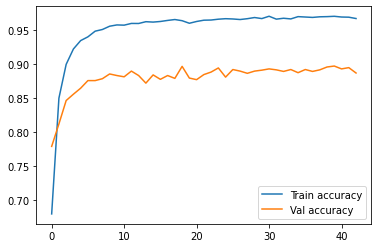

In [ ]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend();

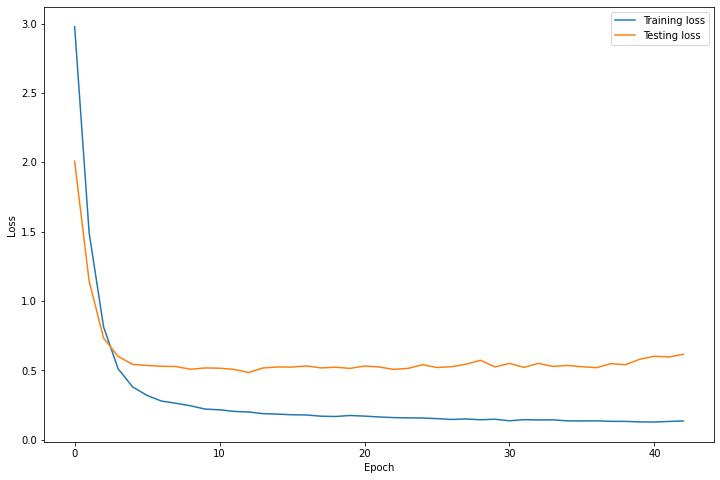

In [ ]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [ ]:
pred = model.predict(X_test_scaled).round()
print('Keras ROC_AUC score :', roc_auc_score(y_test, pred.ravel()))

Keras ROC_AUC score : 0.5925892465346789


*** ROC-AUC of Ridge is 73% compared to 59% from tensorflow ***

###  6.0 In this section, we will formally create pipeline to evaluate several models using GridSearch

In [ ]:
#Define X, and Y
X=df_train.drop(columns=['WnvPresent'])
y=df_train['WnvPresent']

#Train, Test, Split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, shuffle=True)


In [ ]:
# Logistic Regression
logreg = LogisticRegression(
    solver='liblinear',
    max_iter=1000, 
    random_state=42,
)

logreg_params = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.1, 0.5, 1, 1.5, 2.5]
}

# Gradient Boost
gb = GradientBoostingClassifier(random_state=42)
gb_params = {
    'clf__learning_rate': [0.05, 0.1, 0.15],
    'clf__max_depth': [2, 3,4]
}

# Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_params = {
    'clf__n_estimators': [100, 150, 200],
    'clf__max_depth': [4, 5, 6]
}

# Extra Trees
et = ExtraTreesClassifier(random_state=42, n_jobs=-1)
et_params = {
    'clf__n_estimators': [50, 75, 100],
    'clf__max_depth': [4, 5, 6]
}

#Ada Boost Classifier
ada = AdaBoostClassifier()
ada_params = {
    'clf__n_estimators':[50,100,150], 
    'clf__learning_rate':[1,0.1,0.01]
}

#Ridge

ridge = RidgeClassifier()
ridge_params = {'clf__random_state' : [42]}

sgd = SGDClassifier(loss='log', max_iter=1000, random_state=1)
sgd_params = {
    'clf__penalty': ['l1', 'l2', 'elasticnet'],
    'clf__alpha':[.0001, .001, .01],
    'clf__l1_ratio':[.01,.05,.15],
}
# XGBoost
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1
)

xgb_params = { 
    'clf__max_depth': [3, 4,5], #Depth of tree (higher value implies likely overfit)
    'clf__gamma' : [0.1, 0.2 , 0.3], #Min loss reduction required for further partition
    'clf__learning_rate' : [0.1, 0.2], #step size feature weight shrinkage
}

#LightGBM
lgbm = LGBMClassifier()

lgbm_params = {
    'clf__learning_rate': [0.01,0.1],
    'clf__n_estimators': [24,32],
    'clf__num_leaves': [16,24,32], # large num_leaves helps improve accuracy but might lead to over-fitting
    'clf__boosting_type' : ['gbdt'], 
    'clf__objective' : ['binary'],
    'clf__max_bin':[255], # large max_bin helps improve accuracy but might slow down training progress
    'clf__random_state' : [500,1500],
    'clf__colsample_bytree' : [0.65,0.8],
    'clf__subsample' : [0.7,0.8],
    'clf__reg_alpha' : [1.2,1.6],
    'clf__reg_lambda' : [1.4,1.6]
    }

#Ada Boost Classifier
ada = AdaBoostClassifier()

ada_params = {
    'clf__n_estimators':[50,150], 
    'clf__learning_rate':[1,0.1,0.01]
}
# List of classifiers & params
classifiers = [
    (ridge, ridge_params),
    (logreg, logreg_params),
    (gb, gb_params),
    (rf, rf_params),
    (et, et_params),
    (ada, ada_params),
    (sgd, sgd_params),
    (xgb, xgb_params),
    (lgbm, lgbm_params)
]

In [ ]:
def model(clf, clf_params):
    
    start = timeit.timeit()

    pipe = Pipeline(steps = [
                      ('ss', StandardScaler()),
                      ('sm', SMOTE(random_state = 42)), 
                      ('clf', clf)])

    
    # Gridsearch for best estimator
    grid = GridSearchCV(
        pipe,
        param_grid=clf_params,
        scoring='roc_auc',
        verbose=2,
        n_jobs=-1
    )
    grid.fit(X_train,y_train)
    
    print(f'Classifier: {clf}')
    print('Best Parameters:')
    print(grid.best_params_)
    
    
    filename= f"{clf}"[0:10]
    
    # Scoring metrics
    scores = {'Classifier': clf}
    y_train_preds = grid.predict(X_train)
    y_test_preds = grid.predict(X_test)
   
    scores['Train ROC-AUC Score'] = roc_auc_score(y_train, y_train_preds.ravel())
    
    end = timeit.timeit()

    #for Test
    scores['Test ROC-AUC Score'] = roc_auc_score(y_test, y_test_preds.ravel())
    scores['F1'] = f1_score(y_test, y_test_preds)
    scores['Precision'] = precision_score(y_test, y_test_preds)
    scores['Recall'] = recall_score(y_test, y_test_preds)
    scores['Accuracy'] = accuracy_score(y_test, y_test_preds)
    scores['Time'] = end - start
    
    # Storing results
    result.append(scores)
    
    #predicting and export to csv for kaggle submission 
    pred_csv = grid.predict(df_predict.drop(columns=["Id"]))
    pred_submit = pd.DataFrame(pred_csv, columns=['WnvPresent'])
    pred_submit['Id'] = df_predict["Id"].astype(int)


    pred_submit[["Id", 'WnvPresent']].to_csv(f"/work/deepnote_exports/{filename}.csv", index=False)

    return pipe

In [ ]:
# Run through gridsearch for every model
result = []

for (clf, clf_params) in classifiers:
    model(clf, clf_params)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Classifier: RidgeClassifier()
Best Parameters:
{'clf__random_state': 42}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classifier: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
Best Parameters:
{'clf__C': 0.1, 'clf__penalty': 'l1'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Classifier: GradientBoostingClassifier(random_state=42)
Best Parameters:
{'clf__learning_rate': 0.15, 'clf__max_depth': 4}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Classifier: RandomForestClassifier(n_jobs=-1, random_state=42)
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 150}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Classifier: ExtraTreesClassifier(n_jobs=-1, random_state=42)
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 100}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Classifier: AdaBoostClassifier()
Best Parameters:
{'

In [ ]:
# Results sorted by Test ROC-AUC
pd.DataFrame(result).sort_values(by='Test ROC-AUC Score', ascending=False).reset_index(drop=True)

,Classifier,Train ROC-AUC Score,Test ROC-AUC Score,F1,Precision,Recall,Accuracy,Time
0,"ExtraTreesClassifier(n_jobs=-1, random_state=42)",0.774785,0.738673,0.227882,0.134494,0.745614,0.732466,0.000016
1,"SGDClassifier(loss='log', random_state=1)",0.788759,0.719797,0.232772,0.141002,0.666667,0.767301,0.007750
2,RidgeClassifier(),0.792907,0.717534,0.222857,0.133106,0.684211,0.747329,0.060538
3,"RandomForestClassifier(n_jobs=-1, random_state...",0.755718,0.712441,0.222548,0.133568,0.666667,0.753367,0.000402
4,"LogisticRegression(max_iter=1000, random_state...",0.795326,0.709827,0.229199,0.139579,0.640351,0.771946,0.015724
5,AdaBoostClassifier(),0.660231,0.644569,0.298851,0.265306,0.342105,0.915002,-0.000271
6,LGBMClassifier(),0.681134,0.601746,0.258373,0.284211,0.236842,0.928007,0.038061
7,GradientBoostingClassifier(random_state=42),0.677199,0.583249,0.231579,0.289474,0.192982,0.932188,-0.000458
8,"XGBClassifier(base_score=None, booster=None, c...",0.672989,0.575458,0.217391,0.285714,0.175439,0.933117,0.005596


#### If we choose 50% of best features, will the ROC-AUC improve? Adding SelectKBest in the pipeline

In [ ]:
def model_kbest(clf, clf_params):
    
    start = timeit.timeit()

    pipe = Pipeline(steps = [
                      ('ss', StandardScaler()),
                      ('sm', SMOTE(random_state = 42)), 
                      ('selector', SelectKBest(f_classif, k=200)),
                      ('clf', clf)])

    filename= f"{clf}"[0:10]

    # Gridsearch for best estimator
    grid = GridSearchCV(
        pipe,
        param_grid=clf_params,
        scoring='roc_auc',
        verbose=2,
        n_jobs=-1
    )
    grid.fit(X_train,y_train)
    
    print(f'Classifier: {clf}')
    print('Best Parameters:')
    print(grid.best_params_)
    
    # Scoring metrics
    scores = {'Classifier': clf}
    y_train_preds = grid.predict(X_train)
    y_test_preds = grid.predict(X_test)
   
    scores['Train ROC-AUC Score'] = roc_auc_score(y_train, y_train_preds.ravel())
    
    end = timeit.timeit()

    #for Test
    scores['Test ROC-AUC Score'] = roc_auc_score(y_test, y_test_preds.ravel())
    scores['F1'] = f1_score(y_test, y_test_preds)
    scores['Precision'] = precision_score(y_test, y_test_preds)
    scores['Recall'] = recall_score(y_test, y_test_preds)
    scores['Accuracy'] = accuracy_score(y_test, y_test_preds)
    scores['Time'] = end - start

    # Storing results
    result.append(scores)
    
    #predicting and export to csv for kaggle submission 
    pred_csv = grid.predict(df_predict.drop(columns=["Id"]))
    pred_submit = pd.DataFrame(pred_csv, columns=['WnvPresent'])
    pred_submit['Id'] = df_predict["Id"].astype(int)

    pred_submit[["Id", 'WnvPresent']].to_csv(f"/work/deepnote_exports/kbest_{filename}.csv", index=False)

    return pipe

In [ ]:
# Run through gridsearch for every model
result = []

for (clf, clf_params) in classifiers:
    model_kbest(clf, clf_params)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 11  38  39  84 108 109 110 126 153 154 160 161 162 178 190 208 209 216
 237 258 264 278 281 287 302 353 357] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
Classifier: RidgeClassifier()
Best Parameters:
{'clf__random_state': 42}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 11  38  39  84 108 109 110 126 153 154 160 161 162 178 190 208 209 216
 237 258 264 278 281 287 302 353 357] are constant.
  warnings.warn("Features %s

In [ ]:
# Results sorted by Test ROC-AUC with SelectKBest
pd.DataFrame(result).sort_values(by='Test ROC-AUC Score', ascending=False).reset_index(drop=True)

,Classifier,Train ROC-AUC Score,Test ROC-AUC Score,F1,Precision,Recall,Accuracy,Time
0,"ExtraTreesClassifier(n_jobs=-1, random_state=42)",0.774597,0.735786,0.230556,0.136964,0.728070,0.742685,-0.000116
1,"RandomForestClassifier(n_jobs=-1, random_state...",0.751846,0.725080,0.226308,0.134907,0.701754,0.745936,-0.005297
2,"LogisticRegression(max_iter=1000, random_state...",0.794494,0.718081,0.230303,0.139194,0.666667,0.764050,0.007366
3,"SGDClassifier(loss='log', random_state=1)",0.789423,0.715110,0.222865,0.133449,0.675439,0.750581,0.030909
4,RidgeClassifier(),0.786095,0.711432,0.218130,0.130068,0.675439,0.743614,0.072091
5,AdaBoostClassifier(),0.670161,0.628959,0.268657,0.233766,0.315789,0.908964,-0.000161
6,LGBMClassifier(),0.685166,0.613678,0.276498,0.291262,0.263158,0.927078,0.001014
7,GradientBoostingClassifier(random_state=42),0.689881,0.610518,0.274882,0.298969,0.254386,0.928936,0.000589
8,"XGBClassifier(base_score=None, booster=None, c...",0.686094,0.564970,0.190476,0.240000,0.157895,0.928936,-0.002172


## 07. Summary

We have imbalance dataset where the minority is our positive class (WNV is present), and model built with the original dataset is predicting almost everything as negative class (WNV is not present). We addressed the issue by using oversampling through the SMOTE technique.

We look at the coefficient and the top 10 features using RidgeClassifier" weather features like Sunrise, Dewpoint,  featured engineered like Relative Humidity, calculation from the peak day of the presence of WNV  (day_from_max_wnv) and also the rolling average (window function) of some weather features. 

We built several models including deep learning with l1 regularizer, dropout and early stop, however this is still around 59% ROC.

From the pipeline, using GridSearchCSV, ExtraTrees was chosen as best model, with 73% ROC and 74% Recall. To iterate, it will be vital to minimize the cases with false negatives as the resources will not be directed to those in need if the model is not predicting it correctly. As such, we will also have to prioritise the recall - how accurate the model is in identifying west nile virus.

We decided to send the prediction of all models to Kaggle to see how is the ROC-AUC score for each model.
RidgeClassifier tops the ROC-AUC with a score of 70%, second is LR and SGD. Ridge and SGD are both estimators that implement regularized linear models.

We then built another set of pipeline that chooses 200 best features out of 363, with the assumption that selecting features will improve our model, however the result was not so different with  the original one.

For future improvement, we can further analyse how to incorporate spray in our models, and this will improve the false negative if we have more spray data for all years.

**Public Score in Kaggle**

| Model *********** | ROC-AUC *********| w SelectKBest |
| ----------------- | ---------------- | --------------|
| Ridge             |0.70132            |0.69609       |
| LR                |0.68193            |0.68991       |
| SGD               |0.67771            |0.69321       |
| ADA               |0.65550            |0.55385       |
| ET                |0.63570            |0.63139       |
| RF                |0.63302            |0.62832       |
| LGBM              | 0.61089           |0.61815       |
| GB                |0.59286            |0.61269       |
| XGB               |0.58463           |0.57325       |


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3abded61-2db4-446b-a02d-565b62921f1b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>